# Simulation Results Analyzer

This notebook analyzes existing saved simulation results from the `run_simulation_notebook.ipynb` (or its script equivalent).

**Functionality:**
- Loads per-run metrics (`.json` files) from `OUTPUT_DIR_RUN_METRICS_JSON`.
- Loads posterior summaries (mean, quantiles as `.npz` files) for the first MC run of each scenario from `OUTPUT_DIR_POSTERIOR_SUMMARIES`.
- Regenerates true data (`sim_data`) for the first MC run of each scenario using stored seeds to provide context for plots.
- Generates and saves individual time-series plots for the first MC run of each scenario (to `OUTPUT_DIR_PLOTS`).
- Generates and saves a combined 4x3 grid plot of these time-series (to `OUTPUT_DIR_PLOTS`).
- Generates and saves summary box plots for all evaluation metrics across all MC runs (to `OUTPUT_DIR_PLOTS`).
- Aggregates metrics and produces LaTeX summary tables (to `OUTPUT_DIR_TABLES`).

**Prerequisites:**
1. The simulation runner notebook/script must have completed, and its output files must be available in the directories specified in `config.py`.
2. All helper Python modules (`config.py`, `data_generation.py`, etc.) must be in the same directory or accessible.

## 1. Imports and Configuration

In [79]:
import pandas as pd
import numpy as np
import os
import time
import json
from tqdm.auto import tqdm
import importlib

# Import and force-reload all your custom modules to ensure the latest versions are used
import config; importlib.reload(config)
import data_generation; importlib.reload(data_generation)
import benchmarks; importlib.reload(benchmarks)
import evaluation; importlib.reload(evaluation)
import plotting; importlib.reload(plotting)
import tables; importlib.reload(tables)
import results_io; importlib.reload(results_io)

print("All modules have been imported and reloaded.")
print("Reading configuration and output paths from config.py")

All modules have been imported and reloaded.
Reading configuration and output paths from config.py


## 2. Main Analysis Function

In [80]:
def sanitize_metrics_dataframe(df):
    """
    Cleans a DataFrame of metrics by converting list-like values to scalars.
    This is a safeguard against malformed metric files from older runs.
    """
    for col in df.columns:
        if df[col].dtype == 'object':
            # Check if the column contains list-like objects and flatten them
            if df[col].notna().any() and isinstance(df[col].dropna().iloc[0], list):
                df[col] = df[col].apply(
                    lambda x: x[0] if isinstance(x, list) and len(x) == 1 else (np.nan if isinstance(x, list) and len(x) == 0 else x)
                ).astype(float, errors='ignore')
    return df

def prepare_aggregated_plot_data(results_df_all):
    """
    Aggregates time-series results from all valid MC runs for the summary plot.
    This version prepares data for sCFR-O (as requested for plotting) and the benchmarks.
    """
    aggregated_plot_data_list = []
    study_global_seed = config.GLOBAL_BASE_SEED

    for scenario_idx, scenario_config_dict in enumerate(tqdm(config.SCENARIOS, desc="Aggregating Plot Data")):
        scenario_id = scenario_config_dict["id"]
        scenario_base_seed = study_global_seed + (scenario_idx * config.NUM_MONTE_CARLO_RUNS * 1000)
        
        sim_data_true = data_generation.simulate_scenario_data(scenario_config_dict, run_seed=scenario_base_seed)
        T_analyze = config.T_ANALYSIS_LENGTH

        scen_df_valid = results_df_all[(results_df_all["scenario_id"] == scenario_id) & (results_df_all["error"].isin([None, "None"]))]
        if scen_df_valid.empty: continue
        
        # Stacks for collecting time-series data from all valid runs
        sCFR_O_means, sCFR_O_lowers, sCFR_O_uppers = [], [], []
        sCFR_O_cf_means, sCFR_O_cf_lowers, sCFR_O_cf_uppers = [], [], []
        cCFR_means, cCFR_lowers, cCFR_uppers = [], [], []
        aCFR_means, aCFR_lowers, aCFR_uppers = [], [], []
        ITS_factual_means, ITS_factual_lowers, ITS_factual_uppers = [], [], []
        ITS_cf_means, ITS_cf_lowers, ITS_cf_uppers = [], [], []

        for mc_run_idx in scen_df_valid["mc_run"].astype(int) - 1:
            # Load posterior summary for the superior sCFR-O model for plotting
            posterior_summary = results_io.load_posterior_summary_for_run(scenario_id, mc_run_idx, config.OUTPUT_DIR_POSTERIOR_SUMMARIES, model_name="sCFR_O")
            if posterior_summary:
                sCFR_O_means.append(posterior_summary.get("p_mean", []))
                sCFR_O_lowers.append(posterior_summary.get("p_q025", []))
                sCFR_O_uppers.append(posterior_summary.get("p_q975", []))
                sCFR_O_cf_means.append(posterior_summary.get("p_cf_mean", []))
                sCFR_O_cf_lowers.append(posterior_summary.get("p_cf_q025", []))
                sCFR_O_cf_uppers.append(posterior_summary.get("p_cf_q975", []))

            # Regenerate data to calculate benchmarks for this run
            benchmark_results = results_io.load_benchmark_results(
                scenario_id, mc_run_idx, config.OUTPUT_DIR_BENCHMARK_RESULTS
            )
            if benchmark_results:
                cCFR_means.append(benchmark_results.get("cCFR_cumulative", []))
                cCFR_lowers.append(benchmark_results.get("cCFR_cumulative_lower", []))
                cCFR_uppers.append(benchmark_results.get("cCFR_cumulative_upper", []))
                
                aCFR_means.append(benchmark_results.get("aCFR_cumulative", []))
                aCFR_lowers.append(benchmark_results.get("aCFR_cumulative_lower", []))
                aCFR_uppers.append(benchmark_results.get("aCFR_cumulative_upper", []))

                ITS_factual_means.append(benchmark_results.get("its_factual_mean",[]))
                ITS_factual_lowers.append(benchmark_results.get("its_factual_lower",[]))
                ITS_factual_uppers.append(benchmark_results.get("its_factual_upper",[]))
                ITS_cf_means.append(benchmark_results.get("its_counterfactual_mean",[]))
                ITS_cf_lowers.append(benchmark_results.get("its_counterfactual_lower",[]))
                ITS_cf_uppers.append(benchmark_results.get("its_counterfactual_upper",[]))

        # Calculate the point-wise average of the curves and intervals
        agg_plot_dict = {
            "scenario_id": scenario_id,
            "true_r_t": sim_data_true["true_r_0_t"][:T_analyze],
            "true_rcf_0_t": sim_data_true["true_rcf_0_t"][:T_analyze],
            "estimated_r_t_dict": {
                "sCFR": {
                    "mean": np.mean([s for s in sCFR_O_means if len(s)>0], axis=0)[:T_analyze],
                    "lower": np.mean([s for s in sCFR_O_lowers if len(s)>0], axis=0)[:T_analyze],
                    "upper": np.mean([s for s in sCFR_O_uppers if len(s)>0], axis=0)[:T_analyze],
                    "cf_mean": np.mean([s for s in sCFR_O_cf_means if len(s)>0], axis=0)[:T_analyze],
                    "cf_lower": np.mean([s for s in sCFR_O_cf_lowers if len(s)>0], axis=0)[:T_analyze],
                    "cf_upper": np.mean([s for s in sCFR_O_cf_uppers if len(s)>0], axis=0)[:T_analyze]
                },
                "cCFR_cumulative": {
                    "mean": np.mean(cCFR_means, axis=0)[:T_analyze],
                    "lower": np.mean(cCFR_lowers, axis=0)[:T_analyze],
                    "upper": np.mean(cCFR_uppers, axis=0)[:T_analyze]
                },
                "aCFR_cumulative": {
                    "mean": np.mean(aCFR_means, axis=0)[:T_analyze],
                    "lower": np.mean(aCFR_lowers, axis=0)[:T_analyze],
                    "upper": np.mean(aCFR_uppers, axis=0)[:T_analyze]
                },
                "ITS_MLE": {
                    "factual_mean": np.mean(ITS_factual_means, axis=0)[:T_analyze],
                    "factual_lower": np.mean(ITS_factual_lowers, axis=0)[:T_analyze],
                    "factual_upper": np.mean(ITS_factual_uppers, axis=0)[:T_analyze],
                    "cf_mean": np.mean(ITS_cf_means, axis=0)[:T_analyze],
                    "cf_lower": np.mean(ITS_cf_lowers, axis=0)[:T_analyze],
                    "cf_upper": np.mean(ITS_cf_uppers, axis=0)[:T_analyze]
                }
            }
        }
        aggregated_plot_data_list.append(agg_plot_dict)

    return aggregated_plot_data_list

def main_analysis():
    """Main function to orchestrate the post-hoc analysis of simulation results."""
    all_loaded_metrics_list = []
    
    print("Starting analysis of existing simulation results...")
    
    # Create output directories if they don't exist
    for dir_path in [config.OUTPUT_DIR_PLOTS, config.OUTPUT_DIR_TABLES, config.OUTPUT_DIR_RESULTS_CSV]:
        os.makedirs(dir_path, exist_ok=True)

    # --- Load all saved metrics ---
    for scenario_idx, scenario_config_dict in enumerate(tqdm(config.SCENARIOS, desc="Loading All Metrics")):
        scenario_id = scenario_config_dict["id"]
        for mc_run_idx in range(config.NUM_MONTE_CARLO_RUNS):
            run_metrics = results_io.load_run_metrics(scenario_id, mc_run_idx, config.OUTPUT_DIR_RUN_METRICS_JSON)
            if run_metrics:
                all_loaded_metrics_list.append(run_metrics)
    
    if not all_loaded_metrics_list:
        print("No metrics files found. Cannot generate plots or tables.")
        return
        
    results_df_all = pd.DataFrame(all_loaded_metrics_list)
    results_df_valid = sanitize_metrics_dataframe(results_df_all)
    results_df_valid = results_df_valid[results_df_valid['error'].isin([None, "None"])].copy()
    
    if results_df_valid.empty:
        print("No valid simulation runs found. Analysis cannot proceed.")
        return
    
    # --- Prepare data for plotting and tables ---
    cover_cols = [col for col in results_df_valid.columns if 'cover' in col]
    for col in cover_cols:
        results_df_valid[col] = results_df_valid[col].astype('Int64')

    summary_metrics_mean = results_df_valid.groupby("scenario_id").mean(numeric_only=True)
    summary_metrics_std = results_df_valid.groupby("scenario_id").std(numeric_only=True)
    
    summary_metrics_mean = summary_metrics_mean.add_suffix('_mean').rename(columns={'scenario_id_mean':'scenario_id'})
    summary_metrics_std = summary_metrics_std.add_suffix('_std').rename(columns={'scenario_id_std':'scenario_id'})
    results_df_summary_for_tables = pd.merge(summary_metrics_mean, summary_metrics_std, on="scenario_id", how="left")
    
    analysis_csv_path = os.path.join(config.OUTPUT_DIR_RESULTS_CSV, "all_scenarios_metrics_aggregated.csv")
    results_df_summary_for_tables.to_csv(analysis_csv_path, index=False)
    print(f"\nAggregated summary metrics saved to {analysis_csv_path}")

    # --- Generate Plots and Tables ---
    print("\nPreparing aggregated data for summary plot...")
    aggregated_plot_data = prepare_aggregated_plot_data(results_df_all)
    
    print("Generating combined 4x3 aggregated summary plot...")
    plotting.plot_aggregated_scenarios_summary(aggregated_plot_data, config.OUTPUT_DIR_PLOTS)
    
    print("Generating summary boxplots...")
    plotting.plot_metric_summary_boxplots(results_df_valid, config.OUTPUT_DIR_PLOTS)
    
    print("Generating LaTeX summary tables...")
    tables.generate_rt_metrics_table(results_df_summary_for_tables, config.OUTPUT_DIR_TABLES)
    tables.generate_param_metrics_table(results_df_summary_for_tables, config.OUTPUT_DIR_TABLES)

    print("\nAnalysis complete.")
    
# def prepare_aggregated_plot_data(results_df_all):
#     """
#     Aggregates time-series results from all valid MC runs for the summary plot.
#     """
#     aggregated_plot_data_list = []
#     study_global_seed = config.GLOBAL_BASE_SEED

#     for scenario_idx, scenario_config_dict in enumerate(tqdm(config.SCENARIOS, desc="Aggregating Plot Data")):
#         scenario_id = scenario_config_dict["id"]
#         scenario_base_seed = study_global_seed + (scenario_idx * config.NUM_MONTE_CARLO_RUNS * 1000)
        
#         sim_data_true = data_generation.simulate_scenario_data(scenario_config_dict, run_seed=scenario_base_seed)
#         T_analyze = config.T_ANALYSIS_LENGTH

#         # Filter results for valid runs in this scenario
#         scen_df_valid = results_df_all[
#             (results_df_all["scenario_id"] == scenario_id) & 
#             (results_df_all["error"].isin([None, "None"]))
#         ]
#         if scen_df_valid.empty: continue
        
#         # Stacks for collecting time-series from all valid runs
#         sCFR_means, sCFR_lowers, sCFR_uppers, sCFR_cf_means, sCFR_cf_lowers, sCFR_cf_uppers = [], [], [], [], [], []
#         cCFR_means, cCFR_lowers, cCFR_uppers = [], [], []
#         aCFR_means, aCFR_lowers, aCFR_uppers = [], [], []
#         ITS_means, ITS_lowers, ITS_uppers = [], [], []
#         ITS_cf_means, ITS_cf_lowers, ITS_cf_uppers = [], [], []

#         for mc_run_idx in scen_df_valid["mc_run"].astype(int) - 1:
#             posterior_summary = results_io.load_posterior_summary_for_run(scenario_id, mc_run_idx, config.OUTPUT_DIR_POSTERIOR_SUMMARIES)
#             if posterior_summary:
#                 # Append sCFR data
#                 sCFR_means.append(posterior_summary.get("p_mean", []))
#                 sCFR_lowers.append(posterior_summary.get("p_q025", []))
#                 sCFR_uppers.append(posterior_summary.get("p_q975", []))
#                 sCFR_cf_means.append(posterior_summary.get("p_cf_mean", []))
#                 sCFR_cf_lowers.append(posterior_summary.get("p_cf_q025", []))
#                 sCFR_cf_uppers.append(posterior_summary.get("p_cf_q975", []))

#             sim_data_run = data_generation.simulate_scenario_data(scenario_config_dict, run_seed=(scenario_base_seed + mc_run_idx))
#             benchmark_cis = benchmarks.calculate_benchmark_cis_with_bayesian(sim_data_run["d_t"], sim_data_run["c_t"], sim_data_run["f_s_true"])
#             its_results = benchmarks.calculate_its_with_poisson_mle(
#                 d_t=sim_data["d_t"],
#                 c_t=sim_data["c_t"],
#                 f_s=sim_data["f_s_true"],
#                 Bm=sim_data["Bm_true"],
#                 intervention_times_abs=sim_data["true_intervention_times_0_abs"],
#                 intervention_signs=sim_data["beta_signs_true"]
#             )
        
#             # Append benchmark data
#             cCFR_means.append(benchmarks.calculate_crude_cfr(sim_data_run["d_t"], sim_data_run["c_t"], cumulative=True))
#             cCFR_lowers.append(benchmark_cis["cCFR_cumulative_lower"])
#             cCFR_uppers.append(benchmark_cis["cCFR_cumulative_upper"])
            
#             aCFR_means.append(benchmarks.calculate_nishiura_cfr_cumulative(sim_data_run["d_t"], sim_data_run["c_t"], sim_data_run["f_s_true"]))
#             aCFR_lowers.append(benchmark_cis["aCFR_cumulative_lower"])
#             aCFR_uppers.append(benchmark_cis["aCFR_cumulative_upper"])

#         # Calculate the point-wise average of the curves and intervals
#         agg_plot_dict = {
#             "scenario_id": scenario_id,
#             "true_r_t": sim_data_true["true_r_0_t"][:T_analyze],
#             "true_rcf_0_t": sim_data_true["true_rcf_0_t"][:T_analyze],
#             "estimated_r_t_dict": {
#                 "sCFR": {
#                     "mean": np.mean([s for s in sCFR_means if len(s)>0], axis=0)[:T_analyze],
#                     "lower": np.mean([s for s in sCFR_lowers if len(s)>0], axis=0)[:T_analyze],
#                     "upper": np.mean([s for s in sCFR_uppers if len(s)>0], axis=0)[:T_analyze],
#                     "cf_mean": np.mean([s for s in sCFR_cf_means if len(s)>0], axis=0)[:T_analyze],
#                     "cf_lower": np.mean([s for s in sCFR_cf_lowers if len(s)>0], axis=0)[:T_analyze],
#                     "cf_upper": np.mean([s for s in sCFR_cf_uppers if len(s)>0], axis=0)[:T_analyze]
#                 },
#                 "cCFR_cumulative": {
#                     "mean": np.mean(cCFR_means, axis=0)[:T_analyze],
#                     "lower": np.mean(cCFR_lowers, axis=0)[:T_analyze],
#                     "upper": np.mean(cCFR_uppers, axis=0)[:T_analyze]
#                 },
#                 "aCFR_cumulative": {
#                     "mean": np.mean(aCFR_means, axis=0)[:T_analyze],
#                     "lower": np.mean(aCFR_lowers, axis=0)[:T_analyze],
#                     "upper": np.mean(aCFR_uppers, axis=0)[:T_analyze]
#                 },
#                 "ITS_NLS": {
#                     "factual_mean": np.mean(ITS_means, axis=0)[:T_analyze],
#                     "factual_lower": np.mean(ITS_lowers, axis=0)[:T_analyze],
#                     "factual_upper": np.mean(ITS_uppers, axis=0)[:T_analyze],
#                     "cf_mean": np.mean(ITS_cf_means, axis=0)[:T_analyze],
#                     "cf_lower": np.mean(ITS_cf_lowers, axis=0)[:T_analyze],
#                     "cf_upper": np.mean(ITS_cf_uppers, axis=0)[:T_analyze]
#                 }
#             }
#         }
#         aggregated_plot_data_list.append(agg_plot_dict)

#     return aggregated_plot_data_list

# def main_analysis():
#     """
#     Main function to orchestrate the post-hoc analysis of simulation results.
#     """
#     all_loaded_metrics_list = []
#     all_plot_data_for_first_runs = []
    
#     print("Starting analysis of existing simulation results...")
#     start_time_analysis = time.time()

#     for dir_path in [config.OUTPUT_DIR_PLOTS, config.OUTPUT_DIR_TABLES, config.OUTPUT_DIR_RESULTS_CSV]:
#         if not os.path.exists(dir_path): os.makedirs(dir_path)

#     study_global_seed = config.GLOBAL_BASE_SEED

#     for scenario_idx, scenario_config_dict in enumerate(tqdm(config.SCENARIOS, desc="Loading & Preparing Data")):
#         scenario_id = scenario_config_dict["id"]
#         scenario_base_seed = study_global_seed + (scenario_idx * config.NUM_MONTE_CARLO_RUNS * 1000)
        
#         for mc_run_idx in range(config.NUM_MONTE_CARLO_RUNS):
#             run_metrics = results_io.load_run_metrics(scenario_id, mc_run_idx, config.OUTPUT_DIR_RUN_METRICS_JSON)
#             if run_metrics:
#                 all_loaded_metrics_list.append(run_metrics)

#             # Prepare plot data for the first valid MC run of each scenario
#             if mc_run_idx == 0:
#                 run_specific_seed_dgp = scenario_base_seed + mc_run_idx
#                 sim_data = data_generation.simulate_scenario_data(scenario_config_dict, run_seed=run_specific_seed_dgp)
                
#                 posterior_summary = results_io.load_posterior_summary_for_run(
#                     scenario_id, mc_run_idx, config.OUTPUT_DIR_POSTERIOR_SUMMARIES
#                 )
                
#                 if posterior_summary:
#                     T_analyze = config.T_ANALYSIS_LENGTH

#                     sCFR_est_plot = {
#                         "mean": posterior_summary.get("p_mean", np.array([])),
#                         "lower": posterior_summary.get("p_q025", np.array([])),
#                         "upper": posterior_summary.get("p_q975", np.array([])),
#                         "cf_mean": posterior_summary.get("p_cf_mean", np.array([])),
#                         "cf_lower": posterior_summary.get("p_cf_q025", np.array([])),
#                         "cf_upper": posterior_summary.get("p_cf_q975", np.array([]))
#                     }

#                     # r_t_mean_sCFR = posterior_summary.get("p_mean", np.full(T_analyze, np.nan))
#                     # r_t_lower_sCFR = posterior_summary.get("p_q025", np.full(T_analyze, np.nan))
#                     # r_t_upper_sCFR = posterior_summary.get("p_q975", np.full(T_analyze, np.nan))
#                     # rcf_t_mean_sCFR = posterior_summary.get("p_cf_mean", np.full(T_analyze, np.nan))

#                     # Calculate benchmark point estimates                    
#                     benchmark_r_t_estimates = {
#                         "cCFR_cumulative": benchmarks.calculate_crude_cfr(sim_data["d_t"], sim_data["c_t"], cumulative=True),
#                         "aCFR_cumulative": benchmarks.calculate_nishiura_cfr_cumulative(sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"])
#                     }

#                     # Calculate benchmark credible intervals using the Bayesian Beta-Binomial method
#                     benchmark_cis = benchmarks.calculate_benchmark_cis_with_bayesian(
#                         sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"]
#                     )

#                     plot_data_for_run = {
#                             "scenario_id": scenario_id, "mc_run_idx": mc_run_idx,
#                             "true_r_t": sim_data["true_r_0_t"][:T_analyze], 
#                             "true_rcf_0_t": sim_data["true_rcf_0_t"][:T_analyze],
#                             "estimated_r_t_dict": {
#                                 "cCFR_cumulative": {
#                                     "mean": benchmark_r_t_estimates["cCFR_cumulative"][:T_analyze],
#                                     "lower": benchmark_cis["cCFR_cumulative_lower"][:T_analyze],
#                                     "upper": benchmark_cis["cCFR_cumulative_upper"][:T_analyze]
#                                 },
#                                 "aCFR_cumulative": {
#                                     "mean": benchmark_r_t_estimates["aCFR_cumulative"][:T_analyze],
#                                     "lower": benchmark_cis["aCFR_cumulative_lower"][:T_analyze],
#                                     "upper": benchmark_cis["aCFR_cumulative_upper"][:T_analyze]
#                                 }
#                             }
#                         }

#                     plot_data_for_run["estimated_r_t_dict"]["sCFR"] = sCFR_est_plot
#                     all_plot_data_for_first_runs.append(plot_data_for_run)
#                 else:
#                     print(f"  Warning: Posterior summary not found for plotting Scen {scenario_id}, Run {mc_run_idx + 1}.")
    
#     if not all_loaded_metrics_list:
#         print("No metrics files found. Cannot generate plots or tables.")
#         return
        
#     # --- Aggregate results and generate outputs ---
#     results_df_all = pd.DataFrame(all_loaded_metrics_list)
#     results_df_all = sanitize_metrics_dataframe(results_df_all)
#     results_df_valid = results_df_all[results_df_all['error'].isin([None, "None"])].copy()
    
#     if results_df_valid.empty:
#         print("No valid simulation runs found in the loaded metrics. Analysis cannot proceed.")
#         return

#     analysis_csv_path = os.path.join(config.OUTPUT_DIR_RESULTS_CSV, "all_scenarios_metrics_aggregated_by_analyzer.csv")
#     results_df_valid.to_csv(analysis_csv_path, index=False)
#     print(f"\nAggregated valid metrics saved to {analysis_csv_path}")

#     # --- Generate Plots and Tables ---
#     print("\nPreparing aggregated data for summary plot...")
#     aggregated_plot_data = prepare_aggregated_plot_data(results_df_valid)
    
#     print("Generating combined 4x3 aggregated summary plot...")
#     plotting.plot_aggregated_scenarios_summary(aggregated_plot_data, config.OUTPUT_DIR_PLOTS)
    
#     # This part should now work without KeyError because the upstream data is fixed.
#     print("Generating time-series plots from saved summaries...")
#     for p_data in all_plot_data_for_first_runs:
#         plotting.plot_cfr_timeseries_from_data(p_data["scenario_id"], p_data["mc_run_idx"], p_data, config.OUTPUT_DIR_PLOTS)
    
#     print("Generating combined 4x3 summary plot...")
#     plotting.plot_all_scenarios_summary(all_plot_data_for_first_runs, config.OUTPUT_DIR_PLOTS)
    
#     print("Generating summary boxplots from loaded metrics...")
#     plotting.plot_metric_summary_boxplots(results_df_valid, config.OUTPUT_DIR_PLOTS)
    
#     print("Generating LaTeX summary tables from loaded metrics...")
#     # Find all columns that contain 'cover'
#     cover_cols = [col for col in results_df_valid.columns if 'cover' in col]
#     for col in cover_cols:
#         # Convert True/False to 1/0 so that .mean() calculates the coverage probability
#         results_df_valid[col] = results_df_valid[col].astype('Int64')
    
#     summary_metrics_mean = results_df_valid.groupby("scenario_id").mean(numeric_only=True).reset_index()
#     summary_metrics_std = results_df_valid.groupby("scenario_id").std(numeric_only=True).reset_index()
    
#     summary_metrics_mean = summary_metrics_mean.add_suffix('_mean').rename(columns={'scenario_id_mean':'scenario_id'})
#     summary_metrics_std = summary_metrics_std.add_suffix('_std').rename(columns={'scenario_id_std':'scenario_id'})
#     results_df_summary_for_tables = pd.merge(summary_metrics_mean, summary_metrics_std, on="scenario_id", how="left")
    
#     tables.generate_rt_metrics_table(results_df_summary_for_tables, config.OUTPUT_DIR_TABLES)
#     tables.generate_param_metrics_table(results_df_summary_for_tables, config.OUTPUT_DIR_TABLES)

#     end_time_analysis = time.time()
#     print(f"\nAnalysis of existing results complete in {end_time_analysis - start_time_analysis:.2f} seconds.")

In [81]:
# all_loaded_metrics_list = []

# print("Starting analysis of existing simulation results...")

# # Create output directories if they don't exist
# for dir_path in [config.OUTPUT_DIR_PLOTS, config.OUTPUT_DIR_TABLES, config.OUTPUT_DIR_RESULTS_CSV]:
#     os.makedirs(dir_path, exist_ok=True)

# # --- Load all saved metrics ---
# for scenario_idx, scenario_config_dict in enumerate(tqdm(config.SCENARIOS, desc="Loading All Metrics")):
#     scenario_id = scenario_config_dict["id"]
#     for mc_run_idx in range(config.NUM_MONTE_CARLO_RUNS):
#         run_metrics = results_io.load_run_metrics(scenario_id, mc_run_idx, config.OUTPUT_DIR_RUN_METRICS_JSON)
#         if run_metrics:
#             all_loaded_metrics_list.append(run_metrics)

# results_df_all = pd.DataFrame(all_loaded_metrics_list)
# results_df_valid = sanitize_metrics_dataframe(results_df_all)
# results_df_valid = results_df_valid[results_df_valid['error'].isin([None, "None"])].copy()

In [82]:
# aggregated_plot_data_list = []
# study_global_seed = config.GLOBAL_BASE_SEED

# for scenario_idx, scenario_config_dict in enumerate(tqdm(config.SCENARIOS, desc="Aggregating Plot Data")):
#     scenario_id = scenario_config_dict["id"]
#     scenario_base_seed = study_global_seed + (scenario_idx * config.NUM_MONTE_CARLO_RUNS * 1000)
    
#     sim_data_true = data_generation.simulate_scenario_data(scenario_config_dict, run_seed=scenario_base_seed)
#     T_analyze = config.T_ANALYSIS_LENGTH

#     scen_df_valid = results_df_all[(results_df_all["scenario_id"] == scenario_id) & (results_df_all["error"].isin([None, "None"]))]
#     if scen_df_valid.empty: continue
    
#     # Stacks for collecting time-series data from all valid runs
#     sCFR_O_means, sCFR_O_lowers, sCFR_O_uppers = [], [], []
#     sCFR_O_cf_means, sCFR_O_cf_lowers, sCFR_O_cf_uppers = [], [], []
#     cCFR_means, cCFR_lowers, cCFR_uppers = [], [], []
#     aCFR_means, aCFR_lowers, aCFR_uppers = [], [], []
#     ITS_factual_means, ITS_factual_lowers, ITS_factual_uppers = [], [], []
#     ITS_cf_means, ITS_cf_lowers, ITS_cf_uppers = [], [], []

#     for mc_run_idx in scen_df_valid["mc_run"].astype(int) - 1:
#         # Load posterior summary for the superior sCFR-O model for plotting
#         posterior_summary = results_io.load_posterior_summary_for_run(scenario_id, mc_run_idx, config.OUTPUT_DIR_POSTERIOR_SUMMARIES, model_name="sCFR_O")
#         if posterior_summary:
#             sCFR_O_means.append(posterior_summary.get("p_mean", []))
#             sCFR_O_lowers.append(posterior_summary.get("p_q025", []))
#             sCFR_O_uppers.append(posterior_summary.get("p_q975", []))
#             sCFR_O_cf_means.append(posterior_summary.get("p_cf_mean", []))
#             sCFR_O_cf_lowers.append(posterior_summary.get("p_cf_q025", []))
#             sCFR_O_cf_uppers.append(posterior_summary.get("p_cf_q975", []))

#         print("sCFR_O:",sCFR_O_means)

#         # Regenerate data to calculate benchmarks for this run
#         sim_data_run = data_generation.simulate_scenario_data(scenario_config_dict, run_seed=(scenario_base_seed + mc_run_idx))
#         benchmark_cis = benchmarks.calculate_benchmark_cis_with_bayesian(sim_data_run["d_t"], sim_data_run["c_t"], sim_data_run["f_s_true"])
#         its_results = benchmarks.calculate_its_with_parametric_bootstrap(
#             sim_data_run["d_t"], sim_data_run["c_t"], sim_data_run["f_s_true"],
#             sim_data_run["Bm_true"], sim_data_run["true_intervention_times_0_abs"], sim_data_run["beta_signs_true"]
#         )
        
#         cCFR_means.append(benchmarks.calculate_crude_cfr(sim_data_run["d_t"], sim_data_run["c_t"], cumulative=True))
#         cCFR_lowers.append(benchmark_cis["cCFR_cumulative_lower"])
#         cCFR_uppers.append(benchmark_cis["cCFR_cumulative_upper"])
        
#         aCFR_means.append(benchmarks.calculate_nishiura_cfr_cumulative(sim_data_run["d_t"], sim_data_run["c_t"], sim_data_run["f_s_true"]))
#         aCFR_lowers.append(benchmark_cis["aCFR_cumulative_lower"])
#         aCFR_uppers.append(benchmark_cis["aCFR_cumulative_upper"])
        
#         ITS_factual_means.append(its_results["its_factual_mean"])
#         ITS_factual_lowers.append(its_results["its_factual_lower"])
#         ITS_factual_uppers.append(its_results["its_factual_upper"])
#         ITS_cf_means.append(its_results["its_counterfactual_mean"])
#         ITS_cf_lowers.append(its_results["its_counterfactual_lower"])
#         ITS_cf_uppers.append(its_results["its_counterfactual_upper"])

#     # Calculate the point-wise average of the curves and intervals
#     agg_plot_dict = {
#         "scenario_id": scenario_id,
#         "true_r_t": sim_data_true["true_r_0_t"][:T_analyze],
#         "true_rcf_0_t": sim_data_true["true_rcf_0_t"][:T_analyze],
#         "estimated_r_t_dict": {
#             "sCFR-O": {
#                 "mean": np.mean([s for s in sCFR_O_means if len(s)>0], axis=0)[:T_analyze],
#                 "lower": np.mean([s for s in sCFR_O_lowers if len(s)>0], axis=0)[:T_analyze],
#                 "upper": np.mean([s for s in sCFR_O_uppers if len(s)>0], axis=0)[:T_analyze],
#                 "cf_mean": np.mean([s for s in sCFR_O_cf_means if len(s)>0], axis=0)[:T_analyze],
#                 "cf_lower": np.mean([s for s in sCFR_O_cf_lowers if len(s)>0], axis=0)[:T_analyze],
#                 "cf_upper": np.mean([s for s in sCFR_O_cf_uppers if len(s)>0], axis=0)[:T_analyze]
#             },
#             "cCFR_cumulative": {
#                 "mean": np.mean(cCFR_means, axis=0)[:T_analyze],
#                 "lower": np.mean(cCFR_lowers, axis=0)[:T_analyze],
#                 "upper": np.mean(cCFR_uppers, axis=0)[:T_analyze]
#             },
#             "aCFR_cumulative": {
#                 "mean": np.mean(aCFR_means, axis=0)[:T_analyze],
#                 "lower": np.mean(aCFR_lowers, axis=0)[:T_analyze],
#                 "upper": np.mean(aCFR_uppers, axis=0)[:T_analyze]
#             },
#             "ITS_MLE": {
#                 "factual_mean": np.mean(ITS_means, axis=0)[:T_analyze],
#                 "factual_lower": np.mean(ITS_lowers, axis=0)[:T_analyze],
#                 "factual_upper": np.mean(ITS_uppers, axis=0)[:T_analyze],
#                 "cf_mean": np.mean(ITS_cf_means, axis=0)[:T_analyze],
#                 "cf_lower": np.mean(ITS_cf_lowers, axis=0)[:T_analyze],
#                 "cf_upper": np.mean(ITS_cf_uppers, axis=0)[:T_analyze]
#             }
#         }
#     }
#     aggregated_plot_data_list.append(agg_plot_dict)

In [83]:
"""Main function to orchestrate the post-hoc analysis of simulation results."""
all_loaded_metrics_list = []

print("Starting analysis of existing simulation results...")

# Create output directories if they don't exist
for dir_path in [config.OUTPUT_DIR_PLOTS, config.OUTPUT_DIR_TABLES, config.OUTPUT_DIR_RESULTS_CSV]:
    os.makedirs(dir_path, exist_ok=True)

# --- Load all saved metrics ---
for scenario_idx, scenario_config_dict in enumerate(tqdm(config.SCENARIOS, desc="Loading All Metrics")):
    scenario_id = scenario_config_dict["id"]
    for mc_run_idx in range(config.NUM_MONTE_CARLO_RUNS):
        run_metrics = results_io.load_run_metrics(scenario_id, mc_run_idx, config.OUTPUT_DIR_RUN_METRICS_JSON)
        if run_metrics:
            all_loaded_metrics_list.append(run_metrics)

results_df_all = pd.DataFrame(all_loaded_metrics_list)
results_df_valid = sanitize_metrics_dataframe(results_df_all)
results_df_valid = results_df_valid[results_df_valid['error'].isin([None, "None"])].copy()

# --- Prepare data for plotting and tables ---
cover_cols = [col for col in results_df_valid.columns if 'cover' in col]
for col in cover_cols:
    results_df_valid[col] = results_df_valid[col].astype('Int64')

summary_metrics_mean = results_df_valid.groupby("scenario_id").mean(numeric_only=True)
summary_metrics_std = results_df_valid.groupby("scenario_id").std(numeric_only=True)

summary_metrics_mean = summary_metrics_mean.add_suffix('_mean').rename(columns={'scenario_id_mean':'scenario_id'})
summary_metrics_std = summary_metrics_std.add_suffix('_std').rename(columns={'scenario_id_std':'scenario_id'})
results_df_summary_for_tables = pd.merge(summary_metrics_mean, summary_metrics_std, on="scenario_id", how="left")

analysis_csv_path = os.path.join(config.OUTPUT_DIR_RESULTS_CSV, "all_scenarios_metrics_aggregated.csv")
results_df_summary_for_tables.to_csv(analysis_csv_path, index=False)
print(f"\nAggregated summary metrics saved to {analysis_csv_path}")

# --- Generate Plots and Tables ---
print("\nPreparing aggregated data for summary plot...")
aggregated_plot_data = prepare_aggregated_plot_data(results_df_all)

Starting analysis of existing simulation results...


Loading All Metrics:   0%|          | 0/12 [00:00<?, ?it/s]


Aggregated summary metrics saved to ./simulation_outputs/results_csv/all_scenarios_metrics_aggregated.csv

Preparing aggregated data for summary plot...


Aggregating Plot Data:   0%|          | 0/12 [00:00<?, ?it/s]

In [84]:
plotting.plot_aggregated_scenarios_summary(aggregated_plot_data, config.OUTPUT_DIR_PLOTS)

In [57]:
# fig, axes = plt.subplots(4, 3, figsize=(18, 22), sharex=True, sharey=False,
#                          gridspec_kw={'hspace': 0.2, 'wspace': 0.05})

# aggregated_plot_data.sort(key=lambda x: x["scenario_id"])

# # Define row and column titles for the grid
# row_titles = ["Constant", "Linear", "Sinusoidal", "Gaussian"]
# col_titles = ["K=0", "K=1", "K=2"]

# for i, plot_data_dict in enumerate(aggregated_plot_data):
#     if i >= 12: break
#     row_idx, col_idx = i // 3, i % 3
#     ax = axes[row_idx, col_idx]
    
#     T_analyze = len(plot_data_dict["true_r_t"])
#     time_points = np.arange(T_analyze)

#     # Get data dictionaries for cleaner plotting code
#     est_dict = plot_data_dict["estimated_r_t_dict"]
#     sCFR_est = est_dict.get("sCFR", {})
#     cCFR_est = est_dict.get("cCFR_cumulative", {})
#     aCFR_est = est_dict.get("aCFR_cumulative", {})
#     its_est = est_dict.get("ITS_MLE", {})

#     # Plot all curves with their specific labels for the legend
#     ax.plot(time_points, plot_data_dict["true_r_t"], label="True Factual", color='black', linestyle='--')
#     ax.plot(time_points, plot_data_dict["true_rcf_0_t"], label="True Counterfactual", color='dimgray', linestyle=':')
#     ax.plot(time_points, sCFR_est.get("mean", []), label="sCFR_F", color='blue')
#     ax.fill_between(time_points, sCFR_est.get("lower", []), sCFR_est.get("upper", []), color='blue', alpha=0.2, label="sCFR_F 95% CrI")
#     ax.plot(time_points, sCFR_est.get("cf_mean", []), label="sCFR_CF", color='deepskyblue', linestyle='-.')
#     ax.fill_between(time_points, sCFR_est.get("cf_lower", []), sCFR_est.get("cf_upper", []), color='deepskyblue', alpha=0.15, label="sCFR_CF 95% CrI")
    
#     ax.plot(time_points, cCFR_est.get("mean", []), label="cCFR", color='red', linestyle=':')
#     ax.fill_between(time_points, cCFR_est.get("lower", []), cCFR_est.get("upper", []), color='red', alpha=0.15, label="cCFR 95% CrI")
    
#     ax.plot(time_points, aCFR_est.get("mean", []), label="aCFR", color='green', linestyle='-.' )
#     ax.fill_between(time_points, aCFR_est.get("lower", []), aCFR_est.get("upper", []), color='green', alpha=0.15, label="aCFR 95% CrI")
    
#     # ax.plot(time_points, its_est.get("factual_mean", []), label="ITS", color='purple', linestyle=(0, (3, 1, 1, 1))) # dashdotdot
#     # ax.fill_between(time_points, its_est.get("factual_lower", []), its_est.get("factual_upper", []), color='purple', alpha=0.15, label="ITS 95% CI")

#     # ITS factual estimate and its CI
#     ax.plot(time_points, its_est.get("factual_mean", []), label="ITS (Factual)", color='purple', linestyle='--')
#     ax.fill_between(time_points, its_est.get("factual_lower", []), its_est.get("factual_upper", []), color='purple', alpha=0.15, label="ITS 95% CI (Factual)")
    
#     # ITS counterfactual estimate and its CI
#     ax.plot(time_points, its_est.get("cf_mean", []), label="ITS (Counterfactual)", color='magenta', linestyle=':')
#     ax.fill_between(time_points, its_est.get("cf_lower", []), its_est.get("cf_upper", []), color='magenta', alpha=0.15, label="ITS 95% CI (CF)")
    
#     ax.grid(True, linestyle=':', alpha=0.6)
    
#     plotted_vals = np.concatenate([
#         plot_data_dict["true_r_t"], sCFR_est.get("upper", []), aCFR_est.get("upper", [])
#     ])
#     min_val, max_val = np.nanmin(plotted_vals), np.nanmax(plotted_vals)
#     y_padding = (max_val - min_val) * 0.10 if (max_val - min_val) > 0 else 0.01
#     ax.set_ylim(0, max_val + y_padding)

# # --- Set row and column titles ---
# for i, title in enumerate(row_titles):
#     axes[i, 0].set_ylabel(title, fontsize=16, labelpad=15)
# for j, title in enumerate(col_titles):
#     axes[0, j].set_title(title, fontsize=18, pad=10)

In [58]:
handles, labels = axes[0, 0].get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))

row1_labels = ["True Factual", "sCFR_F", "sCFR_CF", "cCFR", "aCFR"]
row2_labels = ["True Counterfactual", "sCFR_F 95% CrI", "sCFR_CF 95% CrI", "cCFR 95% CrI", "aCFR 95% CrI"]

In [59]:
label_to_handle

{'True Factual': <matplotlib.lines.Line2D at 0x24614689550>,
 'True Counterfactual': <matplotlib.lines.Line2D at 0x246148602f0>,
 'sCFR_F': <matplotlib.lines.Line2D at 0x24614860530>,
 'sCFR_F 95% CrI': <matplotlib.collections.PolyCollection at 0x24611c56db0>,
 'sCFR_CF': <matplotlib.lines.Line2D at 0x24616971dc0>,
 'sCFR_CF 95% CrI': <matplotlib.collections.PolyCollection at 0x246148607d0>,
 'cCFR': <matplotlib.lines.Line2D at 0x24614860b90>,
 'cCFR 95% CrI': <matplotlib.collections.PolyCollection at 0x24614860da0>,
 'aCFR': <matplotlib.lines.Line2D at 0x24614861220>,
 'aCFR 95% CrI': <matplotlib.collections.PolyCollection at 0x24616984230>,
 'ITS (Factual)': <matplotlib.lines.Line2D at 0x24614861790>,
 'ITS 95% CI (Factual)': <matplotlib.collections.PolyCollection at 0x246148619a0>,
 'ITS (Counterfactual)': <matplotlib.lines.Line2D at 0x24614861d60>,
 'ITS 95% CI (CF)': <matplotlib.collections.PolyCollection at 0x24614401f70>}

## 3. Execute Analysis

Run the cell below to perform the analysis. Make sure the simulation output directories in `config.py` point to where your simulation results are stored.

Starting analysis of existing simulation results...


Loading All Metrics:   0%|          | 0/12 [00:00<?, ?it/s]


Aggregated summary metrics saved to ./simulation_outputs/results_csv/all_scenarios_metrics_aggregated.csv

Preparing aggregated data for summary plot...


Aggregating Plot Data:   0%|          | 0/12 [00:00<?, ?it/s]

Generating combined 4x3 aggregated summary plot...


ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

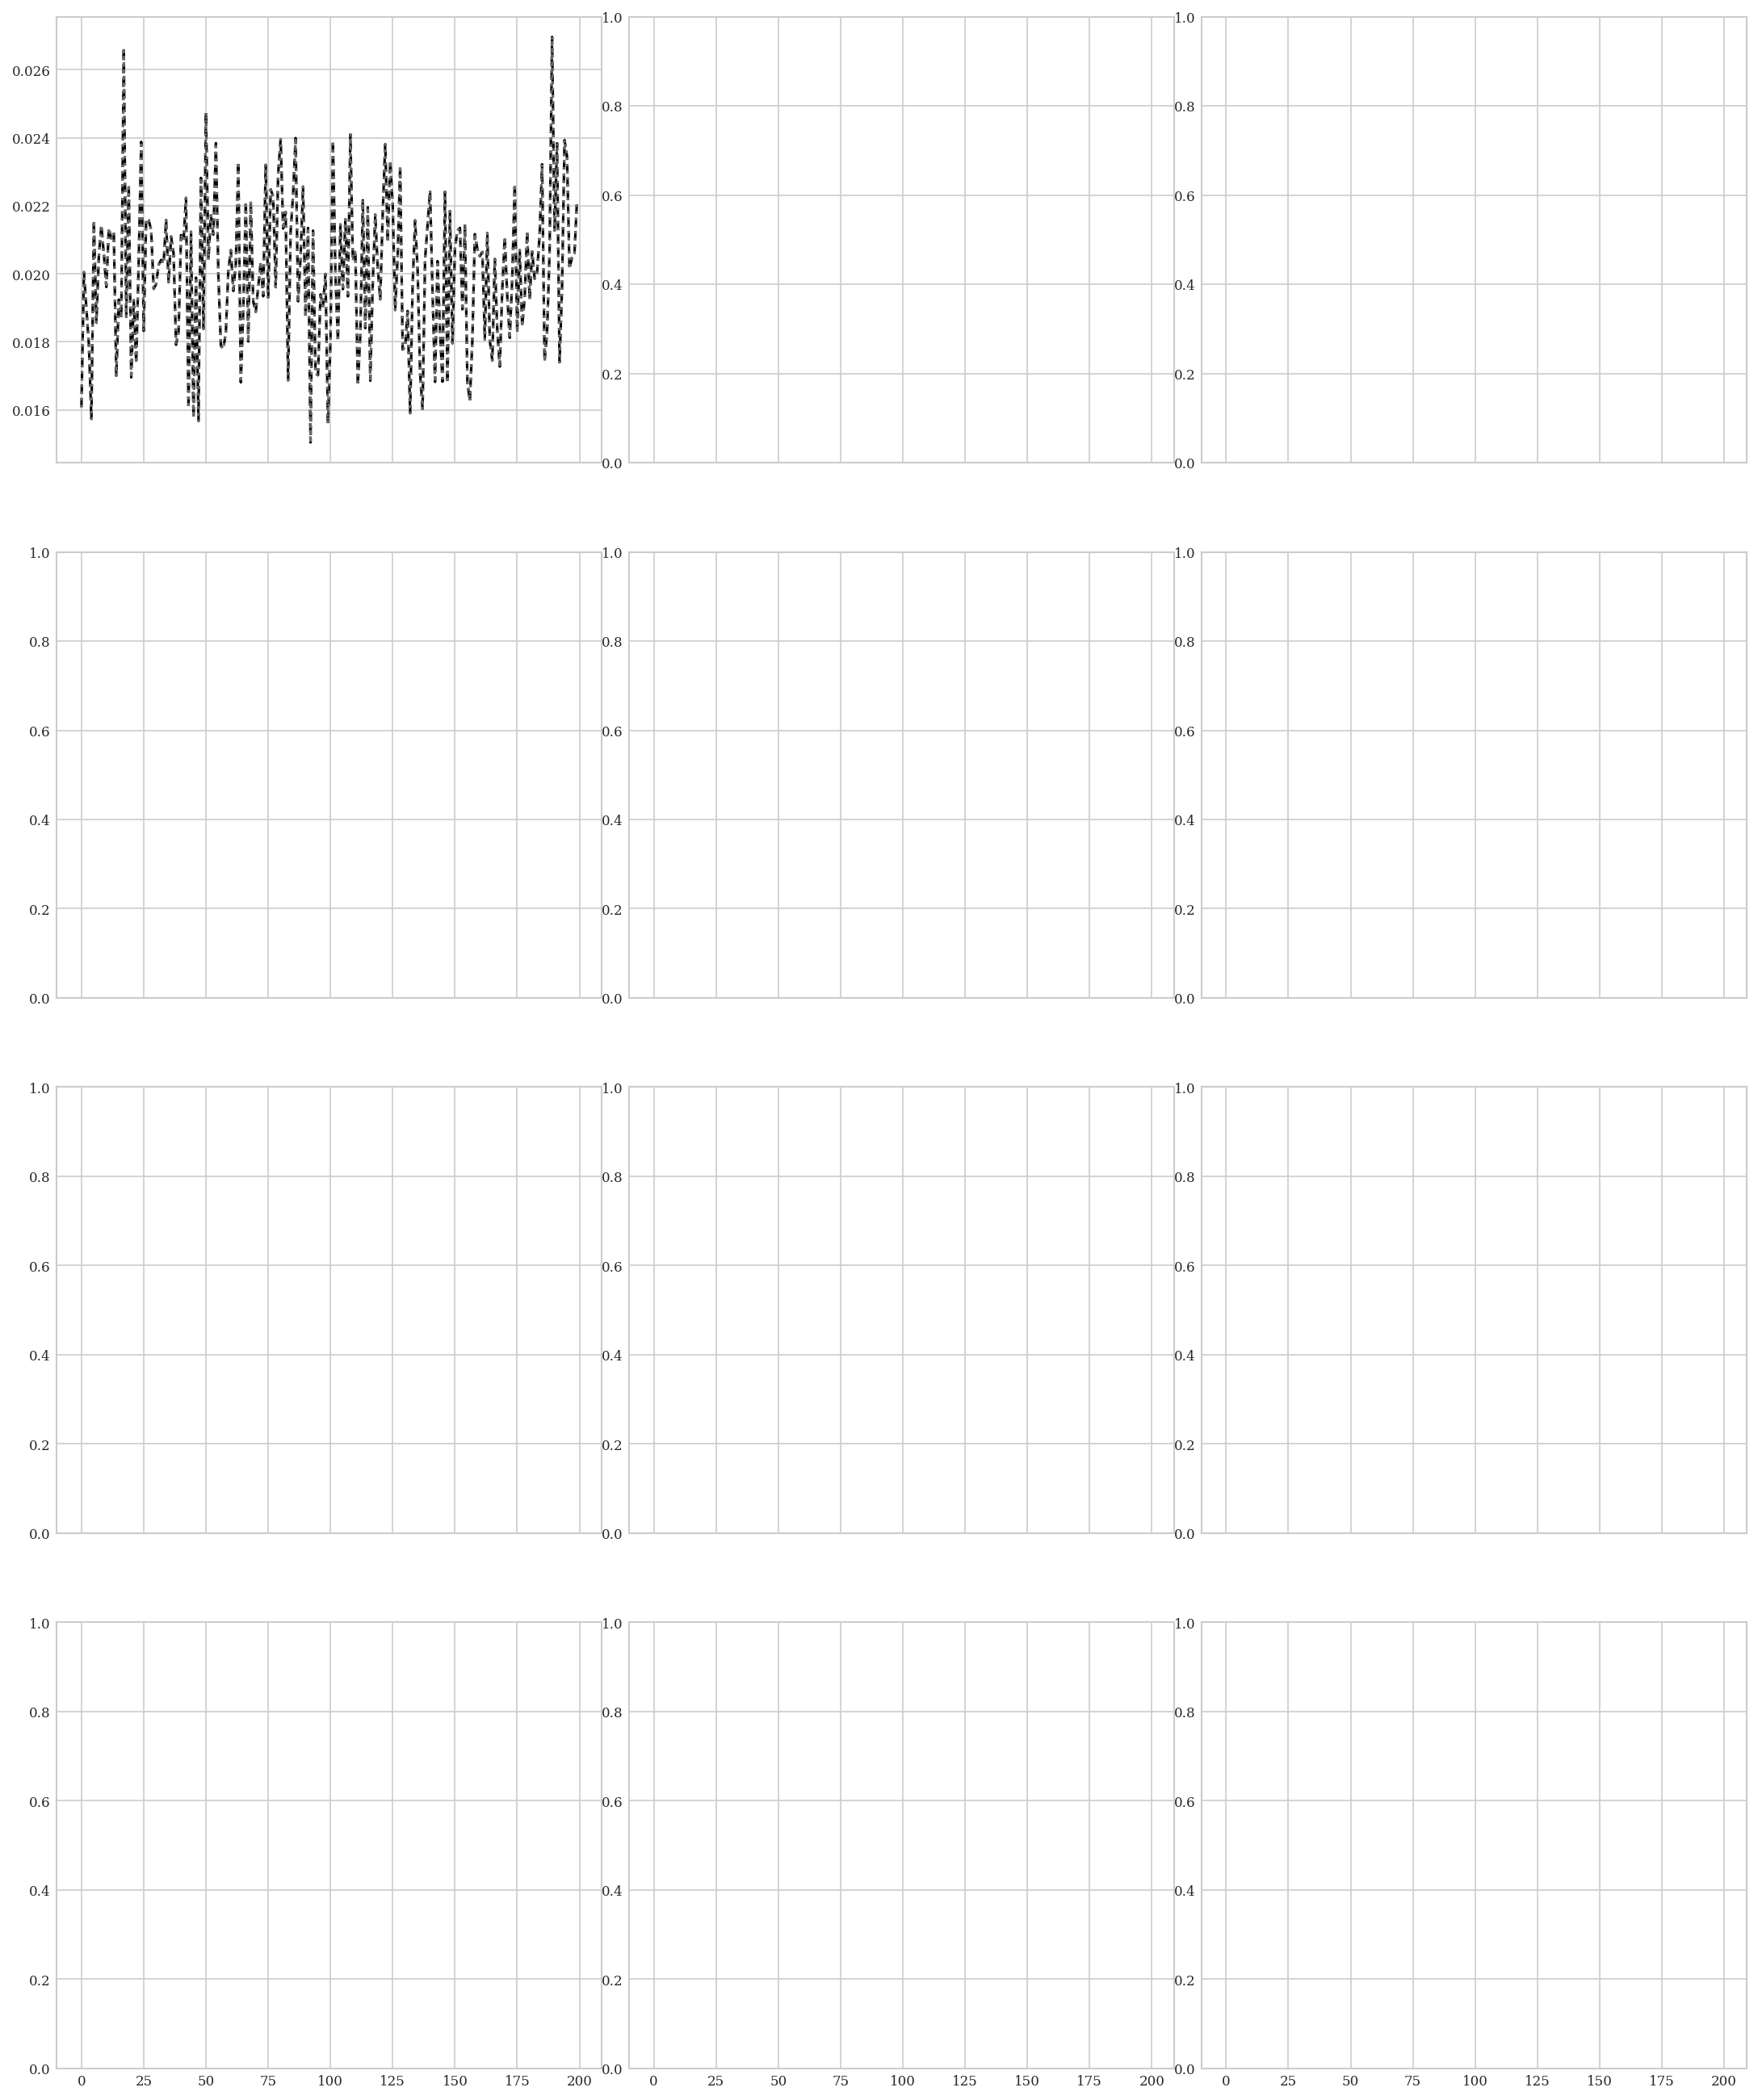

In [5]:
if __name__ == '__main__':
    main_analysis()